# 6 Train Model

## 6.1 Install and load libraries

In [1]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 5.2 MB/s 
     |████████████████████████████████| 181 kB 41.0 MB/s 
     |████████████████████████████████| 145 kB 44.1 MB/s 
     |████████████████████████████████| 63 kB 1.4 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=b48128c78245fa62ed72eca46525f17b71574651580e2cd196c154a4de96a509
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [2]:
import logging
import wandb
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import fbeta_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [3]:
!wandb login --relogin

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## 6.2 Holdout Configuration

In [4]:
# global varaibles

#ratio used to split traind and validation data
val_size = 0.30

# seed used to reproduce purposes
seed = 57

# reference (column) to stratify the data
stratify = "status"

# name of the imput artifact
artifact_input_name = "phishing-detection/train.csv:latest"

# type of the artifact
artifact_type = "Train"

In [5]:
# configure logging
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s %(message)s",
                    datefmt="%Y-%m-%d %H:%M:%S")

# reference for a logging obj
logger = logging.getLogger()

# initiate the wandb project
run = wandb.init(project="phishing-detection",job_type="train")

logger.info("Downloading and reading the train artifact")
local_path = run.use_artifact(artifact_input_name).file()
df_train = pd.read_csv(local_path)

# Spliting train.csv into train and validation dataset
logger.info("Spliting data into train/validation")

# split-out train/validation and test dataset
x_train, x_val, y_train, y_val = train_test_split(df_train.drop(labels=stratify,axis=1),
                                                  df_train[stratify],
                                                  test_size=val_size,
                                                  random_state=seed,
                                                  shuffle=True,
                                                  stratify=df_train[stratify])

wandb: Currently logged in as: lupamedeiros. Use `wandb login --relogin` to force relogin


2022-05-28 13:18:22 Downloading and reading the train artifact
2022-05-28 13:18:23 Spliting data into train/validation


In [6]:
logger.info("x train: {}".format(x_train.shape))
logger.info("y train: {}".format(y_train.shape))
logger.info("x val: {}".format(x_val.shape))
logger.info("y val: {}".format(y_val.shape))

2022-05-28 13:18:26 x train: (6400, 88)
2022-05-28 13:18:26 y train: (6400,)
2022-05-28 13:18:26 x val: (2744, 88)
2022-05-28 13:18:26 y val: (2744,)


## 6.3 Data preparation

### 6.3.1 Outlier Removal


In [7]:
logger.info("Outlier Removal")

#temporary variable
x = x_train.select_dtypes("int64").copy()

# identify outlier in the dataset
lof = LocalOutlierFactor()
outlier = lof.fit_predict(x)
mask = outlier != -1

2022-05-28 13:18:31 Outlier Removal


In [8]:
logger.info("x_train shape [original]: {}".format(x_train.shape))
logger.info("x_train shape [outlier removal]: {}".format(x_train.loc[mask,:].shape))

2022-05-28 13:18:37 x_train shape [original]: (6400, 88)
2022-05-28 13:18:37 x_train shape [outlier removal]: (5650, 88)


In [9]:
# AVOID data leakage and you should not do this procedure in the preprocessing stage
# Note that we did not perform this procedure in the validation set
x_train = x_train.loc[mask,:].copy()
y_train = y_train[mask].copy()

### 6.3.2 Encoding target variable

In [10]:
y_train.head(10)

5437    legitimate
8059    legitimate
8672    legitimate
7984    legitimate
4707      phishing
203     legitimate
2481      phishing
1601    legitimate
4117    legitimate
3453    legitimate
Name: status, dtype: object

In [11]:
logger.info("Encoding Target Variable")
#define a categorial encoding for target varaible
le = LabelEncoder()

# fit and transform y_train
y_train = le.fit_transform(y_train)

# tranform y_test (avoiding data leakage)
y_val = le.transform(y_val)

logger.info("Classes [0, 1]: {}".format(le.inverse_transform([0, 1])))

2022-05-28 13:18:50 Encoding Target Variable
2022-05-28 13:18:50 Classes [0, 1]: ['legitimate' 'phishing']


In [12]:
y_train

array([0, 0, 0, ..., 0, 1, 1])

In [13]:
y_val

array([1, 1, 0, ..., 0, 0, 0])

### 6.3.3 Encoding independent variables

All the variables in this problem are int or float, except for the unique ID (url) and the status.



In [ ]:
x_train.shape

(5650, 88)

In [ ]:
cols=['url']

x_train.drop(labels=cols,axis=1,inplace=True)
x_val.drop(labels=cols,axis=1,inplace=True)

In [ ]:
x_train.head()

,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,nb_eq,...,empty_title,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank
5437,18,10,0,2,0,0,0,0,0,0,...,0,0,1,0,40,5834,22855,0,0,4
8059,42,18,0,2,0,0,0,0,0,0,...,0,0,1,0,297,9200,685,0,0,6
8672,54,19,0,2,2,0,0,0,0,0,...,0,1,0,0,258,4855,128132,0,0,4
7984,56,25,0,2,0,0,0,0,0,0,...,0,1,1,0,2508,6257,689,0,0,6
4707,26,18,0,2,0,0,0,0,0,0,...,1,1,0,0,275,3377,599013,0,1,3


In [ ]:
x_val.head()

,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,nb_eq,...,empty_title,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank
3830,52,16,0,2,2,0,0,0,0,0,...,0,0,0,0,2976,8346,1,0,0,10
4077,68,23,1,3,0,0,1,0,0,0,...,0,1,1,0,298,1528,0,0,1,0
683,41,17,0,2,0,0,0,0,0,0,...,0,1,1,0,304,9557,4204,0,0,7
2017,85,18,1,4,0,0,0,0,0,0,...,1,1,0,0,290,-1,0,0,1,0
6922,66,19,0,3,1,0,0,0,0,0,...,1,1,1,0,0,-1,60011,0,0,4


In [ ]:
run.finish()

### 6.3.4 Building a full-pipeline

Here we are going to create a full-pipeline to proccess the inputs. Both for training and running.

In order to run properly, it is important to re-run cells at sections:


*   6.2 Holdout Configuration
*   6.3.1 Outlier Removal
*   6.3.2 Encoding Target Variable

<br>

#### 6.3.4.1 Feature Extractor

In [14]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    # Class Constructor
    def __init__(self, feature_names):
        self.feature_names = feature_names

    # Return self. Nothing else to do here
    def fit(self, X, y=None):
        return self

    # Method taht describes what this custom transformer need to do
    def transform(self, X, y=None):
        return X[self.feature_names]

In [15]:
# for validation purposes
fs = FeatureSelector(x_train.select_dtypes("object").columns.to_list())
df = fs.fit_transform(x_train)
df.head()

,url
5437,http://www.cel.ro/
8059,http://www.dictionary.com/browse/collision
8672,http://securityxploded.com/router-password-kra...
7984,http://www.thefreedictionary.com/Word+processi...
4707,http://faleupas.kissr.com/


In [16]:
fs = FeatureSelector(x_train.select_dtypes("int64").columns.to_list())
df = fs.fit_transform(x_train)
df.head()

,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,nb_eq,...,empty_title,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank
5437,18,10,0,2,0,0,0,0,0,0,...,0,0,1,0,40,5834,22855,0,0,4
8059,42,18,0,2,0,0,0,0,0,0,...,0,0,1,0,297,9200,685,0,0,6
8672,54,19,0,2,2,0,0,0,0,0,...,0,1,0,0,258,4855,128132,0,0,4
7984,56,25,0,2,0,0,0,0,0,0,...,0,1,1,0,2508,6257,689,0,0,6
4707,26,18,0,2,0,0,0,0,0,0,...,1,1,0,0,275,3377,599013,0,1,3


In [17]:
fs = FeatureSelector(x_train.select_dtypes("float").columns.to_list())
df = fs.fit_transform(x_train)
df.head()

,ratio_digits_url,ratio_digits_host,avg_words_raw,avg_word_host,avg_word_path,ratio_intHyperlinks,ratio_extHyperlinks,ratio_extRedirection,ratio_extErrors,links_in_tags,ratio_intMedia,ratio_extMedia,safe_anchor
5437,0.0,0.0,3.000000,3.0,0.0,0.529412,0.470588,1.000000,0.00,16.666667,0.0,100.0,100.000000
8059,0.0,0.0,7.000000,6.5,7.5,0.781955,0.218045,0.379310,0.00,90.476190,0.0,100.0,16.129032
8672,0.0,0.0,7.800000,15.0,6.0,0.887755,0.112245,0.727273,0.00,0.000000,50.0,50.0,52.941176
7984,0.0,0.0,14.333333,10.0,23.0,0.939024,0.060976,0.000000,0.05,61.538462,100.0,0.0,72.727273
4707,0.0,0.0,6.500000,6.5,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.0,0.000000


#### 6.3.4.2 Handling Categorical Features

Just removing the url input.

In [18]:
# Handling categorical Features
class CategoricalTransformer(BaseEstimator, TransformerMixin):
    # Class constructor method that takes one boolean as its argument
    def __init__(self, new_features=True, colnames=None):
        self.new_features = new_features
        self.colnames = colnames

    # Return self. Nothing to do here
    def fit(self, X, y=None):
        return self

    def get_features_names_out(self):
        return self.colnames.tolist()

    # Transformer method we wrote for this transformer
    def transform(self, X, y=None):
        df = pd.DataFrame(X, columns=self.colnames)

        # Remove white space in categorical features
        # df = df.apply(lambda row: row.str.strip())

        # Customize features - Defined by EDA

        if self.new_features:
            # drop the url feature
            cols_to_remove = ['url']

            df.drop(labels=cols_to_remove,axis=1,inplace=True)

        return df


In [19]:
# for validation purposes

fs = FeatureSelector(x_train.select_dtypes("object").columns.to_list())
df = fs.fit_transform(x_train)
df.head()

,url
5437,http://www.cel.ro/
8059,http://www.dictionary.com/browse/collision
8672,http://securityxploded.com/router-password-kra...
7984,http://www.thefreedictionary.com/Word+processi...
4707,http://faleupas.kissr.com/


In [20]:
# for validanting purposes
ct = CategoricalTransformer(new_features=True,colnames=df.columns.tolist())
df_cat = ct.fit_transform(df)
df_cat.head()

""
5437
8059
8672
7984
4707


#### 6.3.4.3 Handdling Numerical Features

In [21]:
# Transform numerical features
class NumericalTransformer(BaseEstimator, TransformerMixin):
    # Class constructor method that takes a model parameter as its argument
    # model 0: minmax
    # model 1: standard
    # model 2: no scaler
    def __init__(self, model=0, colnames=None):
        self.model = model
        self.colnames = colnames
        self.scaler = None

    # Fit is used only to learn statiscal about scalers
    def fit(self, X, y=None):
        df = pd.DataFrame(X, columns=self.colnames)
        # minmax
        if self.model == 0:
            self.scaler = MinMaxScaler()
            self.scaler.fit(df)
        # standard scaler
        elif self.model == 1:
            self.scaler = StandardScaler()
            self.scaler.fit(df)
        return self

    # return columns names after transformation
    def get_feature_names_out(self):
        return self.colnames

    # Transformer method we wrote for this transformer
    # Use fitted scalers
    def transform(self, X, y=None):
        df = pd.DataFrame(X, columns=self.colnames)

        #update columns name
        self.colnames = df.columns.tolist()

        # minmax
        if self.model == 0:
            df = self.scaler.transform(df)
        elif self.model == 1:
            df = self.scaler.transform(df)
        else:
            df = df.values

        return df

In [22]:
# for validation purposes
fs = FeatureSelector(x_train.select_dtypes(["int64","float"]).columns.to_list())
df = fs.fit_transform(x_train)
df.head()

,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,nb_eq,...,empty_title,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank
5437,18,10,0,2,0,0,0,0,0,0,...,0,0,1,0,40,5834,22855,0,0,4
8059,42,18,0,2,0,0,0,0,0,0,...,0,0,1,0,297,9200,685,0,0,6
8672,54,19,0,2,2,0,0,0,0,0,...,0,1,0,0,258,4855,128132,0,0,4
7984,56,25,0,2,0,0,0,0,0,0,...,0,1,1,0,2508,6257,689,0,0,6
4707,26,18,0,2,0,0,0,0,0,0,...,1,1,0,0,275,3377,599013,0,1,3


In [23]:
# for validation purposes
nt = NumericalTransformer(model=1)
df_num = nt.fit_transform(df)
df_num

array([[-0.98384014, -1.19774111, -0.39990761, ..., -0.14979779,
        -1.05946416,  0.33517078],
       [-0.3853371 , -0.29557813, -0.39990761, ..., -0.14979779,
        -1.05946416,  1.13946677],
       [-0.08608557, -0.18280776, -0.39990761, ..., -0.14979779,
        -1.05946416,  0.33517078],
       ...,
       [-0.70952625,  0.15550336, -0.39990761, ..., -0.14979779,
        -1.05946416,  0.73731878],
       [-0.68458862,  0.15550336, -0.39990761, ..., -0.14979779,
         0.94387336,  0.73731878],
       [ 0.28797883,  1.39597745, -0.39990761, ..., -0.14979779,
         0.94387336, -0.87127321]])

In [24]:
# return columns name
nt.get_feature_names_out()

['length_url',
 'length_hostname',
 'ip',
 'nb_dots',
 'nb_hyphens',
 'nb_at',
 'nb_qm',
 'nb_and',
 'nb_or',
 'nb_eq',
 'nb_underscore',
 'nb_tilde',
 'nb_percent',
 'nb_slash',
 'nb_star',
 'nb_colon',
 'nb_comma',
 'nb_semicolumn',
 'nb_dollar',
 'nb_space',
 'nb_www',
 'nb_com',
 'nb_dslash',
 'http_in_path',
 'https_token',
 'ratio_digits_url',
 'ratio_digits_host',
 'punycode',
 'port',
 'tld_in_path',
 'tld_in_subdomain',
 'abnormal_subdomain',
 'nb_subdomains',
 'prefix_suffix',
 'random_domain',
 'shortening_service',
 'path_extension',
 'nb_redirection',
 'nb_external_redirection',
 'length_words_raw',
 'char_repeat',
 'shortest_words_raw',
 'shortest_word_host',
 'shortest_word_path',
 'longest_words_raw',
 'longest_word_host',
 'longest_word_path',
 'avg_words_raw',
 'avg_word_host',
 'avg_word_path',
 'phish_hints',
 'domain_in_brand',
 'brand_in_subdomain',
 'brand_in_path',
 'suspecious_tld',
 'statistical_report',
 'nb_hyperlinks',
 'ratio_intHyperlinks',
 'ratio_extHyp

#### 6.3.4.5 Data Preparation Pipeline

In [25]:
from pandas.core.arrays import categorical
# model = 0 (min-max), 1 (z-score), 2 (no normalization)
numerical_model = 0

# categorical features to pass down the categorical pipeline
categorical_features = x_train.select_dtypes("object").columns.to_list()

# Numerical features to pass down the numerical pipeline
numerical_features = x_train.select_dtypes(["int64","float"]).columns.to_list()

# Defining the steps for the categorical pipeline
categorical_pipeline = Pipeline(steps=[('cat_selector', FeatureSelector(categorical_features)),
                                       ('imputer_cat', SimpleImputer(strategy="most_frequent")),
                                       ('cat_transformer', CategoricalTransformer(colnames=categorical_features)),
                                       ('cat_encoder', 'passthrough')
                                      ]
                               )

# defining the steps in the numerical pipeline
numerical_pipeline = Pipeline(steps=[('num_selector', FeatureSelector(numerical_features)),
                                     ('imputer_num', SimpleImputer(strategy="median")),
                                     ('num_transformer', NumericalTransformer(numerical_model,
                                                                              colnames=numerical_features))
                                    ]
                             )
# Combine numerical and categorical pieplines into one full big pipeline horizontally
full_pipeline_preprocessing = FeatureUnion(transformer_list=[('cat_pipeline', categorical_pipeline),
                                                             ('num_pipeline', numerical_pipeline)
                                                            ]
                                          )

In [26]:
# for validation purposes
new_data = full_pipeline_preprocessing.fit_transform(x_train)
# cat_names is a numpy array
# cat_names = full_pipeline_preprocessing.get_params()["cat_pipeline"][3].get_feature_names_out().tolist()
# num_names is a list
num_names = full_pipeline_preprocessing.get_params()["num_pipeline"][2].get_feature_names_out()

df = pd.DataFrame(new_data,columns = num_names)
df.head()

,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,nb_eq,...,empty_title,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank
0,0.01227,0.065934,0.0,0.047619,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.001379,0.453246,0.002127,0.0,0.0,0.4
1,0.06135,0.153846,0.0,0.047619,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.010025,0.714663,0.000064,0.0,0.0,0.6
2,0.08589,0.164835,0.0,0.047619,0.046512,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.008713,0.377213,0.011924,0.0,0.0,0.4
3,0.08998,0.230769,0.0,0.047619,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.084404,0.486098,0.000064,0.0,0.0,0.6
4,0.02863,0.153846,0.0,0.047619,0.000000,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.009285,0.262426,0.055744,0.0,1.0,0.3


## 6.4 Holdout Training

In this example the inference artifacts are:

*    pipe: cotains trained molde and the preprocessing pipeline
*    le: lecabel enconder object used to encode target variable

In [ ]:
# The full pipeline
pipe = Pipeline(steps = [('full_pipeline', full_pipeline_preprocessing),
                         ("classifier", DecisionTreeClassifier())
                        ]
               )

# Trainning
logger.info("Trainnig")
pipe.fit(x_train,y_train)

# Predict
logger.info("Infering")
predict = pipe.predict(x_val)

# Evaluation Metrics
logger.info("Evaluation metrics")
fbeta = fbeta_score(y_val, predict, beta=1, zero_division=1)
precision = precision_score(y_val, predict, zero_division=1)
recall = recall_score(y_val, predict, zero_division=1)
acc = accuracy_score(y_val, predict)

logger.info("Accuracy: {}".format(acc))
logger.info("Precision: {}".format(precision))
logger.info("Recall: {}".format(recall))
logger.info("F1: {}".format(fbeta))

2022-05-28 00:06:30 Trainnig
2022-05-28 00:06:30 Infering
2022-05-28 00:06:30 Evaluation metrics
2022-05-28 00:06:30 Accuracy: 0.9336734693877551
2022-05-28 00:06:30 Precision: 0.9349415204678363
2022-05-28 00:06:30 Recall: 0.9322157434402333
2022-05-28 00:06:30 F1: 0.9335766423357664


In [ ]:
run.summary["Acc"] = acc
run.summary["Precision"] = precision
run.summary["Recall"] = recall
run.summary["F1"] = fbeta

In [ ]:
# predict bias
logger.info("Infering Bias")
predict_bias = pipe.predict(x_train)

# Evaluation Metrics
logger.info("Bias Evaluation metrics")
fbeta = fbeta_score(y_train, predict_bias, beta=1, zero_division=1)
precision = precision_score(y_train, predict_bias, zero_division=1)
recall = recall_score(y_train, predict_bias, zero_division=1)
acc = accuracy_score(y_train, predict_bias)

logger.info("Bias Accuracy: {}".format(acc))
logger.info("Bias Precision: {}".format(precision))
logger.info("Bias Recall: {}".format(recall))
logger.info("Bias F1: {}".format(fbeta))

2022-05-28 00:07:33 Infering Bias
2022-05-28 00:07:33 Bias Evaluation metrics
2022-05-28 00:07:33 Bias Accuracy: 1.0
2022-05-28 00:07:33 Bias Precision: 1.0
2022-05-28 00:07:33 Bias Recall: 1.0
2022-05-28 00:07:33 Bias F1: 1.0


In [ ]:
# Compare the accuracy, precision, recall with previous ones
print(classification_report(y_val,predict))

              precision    recall  f1-score   support

           0       0.93      0.94      0.93      1372
           1       0.93      0.93      0.93      1372

    accuracy                           0.93      2744
   macro avg       0.93      0.93      0.93      2744
weighted avg       0.93      0.93      0.93      2744



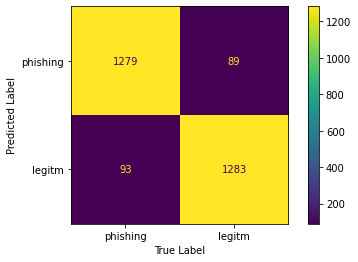

In [ ]:
fig_confusion_matrix, ax = plt.subplots(1,1,figsize=(7,4))
ConfusionMatrixDisplay(confusion_matrix(predict,y_val,labels=[1,0]),
                       display_labels=["phishing","legitm"]).plot(values_format=".0f",ax=ax)

ax.set_xlabel("True Label")
ax.set_ylabel("Predicted Label")
plt.show()

In [ ]:
# Uploading figures
logger.info("Uploading figures")
run.log(
    {
        "confusion_matrix": wandb.Image(fig_confusion_matrix),
        # "other_figure": wandb.Image(other_fig)
    }
)

2022-05-28 00:09:12 Uploading figures


In [ ]:
# Feature importance
pipe.get_params()["classifier"].feature_importances_

array([6.19761265e-03, 1.89623565e-02, 6.07009423e-04, 2.44230335e-03,
       1.20647342e-02, 0.00000000e+00, 3.94909318e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 6.01391753e-03, 0.00000000e+00, 1.11931148e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.11905676e-03,
       3.93755188e-02, 3.97312737e-03, 0.00000000e+00, 0.00000000e+00,
       8.26207270e-04, 2.75053434e-03, 3.25643850e-03, 0.00000000e+00,
       6.22179610e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.53099652e-03, 1.79405007e-03, 9.33734251e-04, 6.37359894e-04,
       0.00000000e+00, 6.14448263e-04, 0.00000000e+00, 6.83010594e-03,
       1.53438493e-03, 1.07729813e-03, 8.35038402e-03, 1.03414845e-02,
       2.27609541e-03, 4.37700158e-04, 1.59822412e-02, 6.37940135e-03,
       3.43274061e-03, 1.73503527e-03, 1.41656138e-02, 2.00817700e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 6.27554357e-04,
      

In [ ]:
# Get categorical column names
cat_names = pipe.named_steps['full_pipeline'].get_params()["cat_pipeline"][3].get_feature_names_out().tolist()
cat_names

AttributeError: ignored

In [ ]:
# Get numerical column names
num_names = pipe.named_steps['full_pipeline'].get_params()["num_pipeline"][2].get_feature_names_out()
num_names

['length_url',
 'length_hostname',
 'ip',
 'nb_dots',
 'nb_hyphens',
 'nb_at',
 'nb_qm',
 'nb_and',
 'nb_or',
 'nb_eq',
 'nb_underscore',
 'nb_tilde',
 'nb_percent',
 'nb_slash',
 'nb_star',
 'nb_colon',
 'nb_comma',
 'nb_semicolumn',
 'nb_dollar',
 'nb_space',
 'nb_www',
 'nb_com',
 'nb_dslash',
 'http_in_path',
 'https_token',
 'ratio_digits_url',
 'ratio_digits_host',
 'punycode',
 'port',
 'tld_in_path',
 'tld_in_subdomain',
 'abnormal_subdomain',
 'nb_subdomains',
 'prefix_suffix',
 'random_domain',
 'shortening_service',
 'path_extension',
 'nb_redirection',
 'nb_external_redirection',
 'length_words_raw',
 'char_repeat',
 'shortest_words_raw',
 'shortest_word_host',
 'shortest_word_path',
 'longest_words_raw',
 'longest_word_host',
 'longest_word_path',
 'avg_words_raw',
 'avg_word_host',
 'avg_word_path',
 'phish_hints',
 'domain_in_brand',
 'brand_in_subdomain',
 'brand_in_path',
 'suspecious_tld',
 'statistical_report',
 'nb_hyperlinks',
 'ratio_intHyperlinks',
 'ratio_extHyp

In [ ]:
# merge all column names together
# all_names = cat_names + num_names
all_names = num_names
all_names

['length_url',
 'length_hostname',
 'ip',
 'nb_dots',
 'nb_hyphens',
 'nb_at',
 'nb_qm',
 'nb_and',
 'nb_or',
 'nb_eq',
 'nb_underscore',
 'nb_tilde',
 'nb_percent',
 'nb_slash',
 'nb_star',
 'nb_colon',
 'nb_comma',
 'nb_semicolumn',
 'nb_dollar',
 'nb_space',
 'nb_www',
 'nb_com',
 'nb_dslash',
 'http_in_path',
 'https_token',
 'ratio_digits_url',
 'ratio_digits_host',
 'punycode',
 'port',
 'tld_in_path',
 'tld_in_subdomain',
 'abnormal_subdomain',
 'nb_subdomains',
 'prefix_suffix',
 'random_domain',
 'shortening_service',
 'path_extension',
 'nb_redirection',
 'nb_external_redirection',
 'length_words_raw',
 'char_repeat',
 'shortest_words_raw',
 'shortest_word_host',
 'shortest_word_path',
 'longest_words_raw',
 'longest_word_host',
 'longest_word_path',
 'avg_words_raw',
 'avg_word_host',
 'avg_word_path',
 'phish_hints',
 'domain_in_brand',
 'brand_in_subdomain',
 'brand_in_path',
 'suspecious_tld',
 'statistical_report',
 'nb_hyperlinks',
 'ratio_intHyperlinks',
 'ratio_extHyp

In [ ]:
# Visualize all classifier plots
# For a complete documentation please see: https://docs.wandb.ai/guides/integrations/scikit
wandb.sklearn.plot_classifier(pipe.get_params()["classifier"],
                              full_pipeline_preprocessing.transform(x_train),
                              full_pipeline_preprocessing.transform(x_val),
                              y_train,
                              y_val,
                              predict,
                              pipe.predict_proba(x_val),
                              [0,1],
                              model_name='DT', feature_names=all_names)

wandb: 
wandb: Plotting DT.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: WARNING wandb.plots.* functions are deprecated and will be removed in a future release. Please use wandb.plot.* instead.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


In [ ]:
# Visualize single plot
# wandb.sklearn.plot_confusion_matrix(y_val, predict, [0,1])

In [ ]:
# Catch up the class proportions between train and validation
# wandb.sklearn.plot_class_proportions(y_train, y_val, [0,1])

In [ ]:
# Plot the importance of columns
# wandb.sklearn.plot_feature_importances(pipe.get_params()["classifier"],all_names)

In [ ]:
# Plot a brief summary of the weighted avg results (recall, precision, f1, acc)
# wandb.sklearn.plot_summary_metrics(pipe.get_params()["classifier"],
#                                    full_pipeline_preprocessing.transform(x_train),
#                                    y_train,
#                                    full_pipeline_preprocessing.transform(x_val),
#                                    y_val)

In [ ]:
# ROC curve
# predict_proba = pipe.predict_proba(x_val)
# wandb.sklearn.plot_roc(y_val, predict_proba, [0,1])

In [ ]:
# close the current run before to execute the next section
run.finish()

Acc,0.93367
F1,0.93358
Precision,0.93494
Recall,0.93222


## 6.5 Hyperparamenter Tuning

In [ ]:
# To see all paramenters fo a specific step of the pipeline
# pipe.named_steps['classifier'].get_params() 
# or
# pipe.named_steps['full_pipeline'].get_params()

In [ ]:
# global seed
seed = 57

In [ ]:
sweep_config = {
    # try grid or random
    "method": "random",
    "metric": {
        "name": "Accuracy",
        "goal" : "maximize"
    },
    "parameters": {
        "criterion": {
            "values": ["gini", "entropy"]
        },
        "splitter": {
            "values": ["random","best"]
        },
        "model": {
            "values": [0,1,2]
        },
        "random_state": {
            "values": [seed]
        }
    }
}

sweep_id = wandb.sweep(sweep_config, project="phishing-detection")

Create sweep with ID: 1yy1bpdu
Sweep URL: https://wandb.ai/lupamedeiros/phishing-detection/sweeps/1yy1bpdu


In [ ]:
def train():
    with wandb.init() as run:

        # The full pipeline
        pipe = Pipeline(steps = [('full_pipeline', full_pipeline_preprocessing),
                                 ("classifier", DecisionTreeClassifier())
                                ]
                        )
        
        # update the parameters of the pipeline that we would like to tuning
        pipe.set_params(**{"full_pipeline__num_pipeline__num_transformer__model": run.config.model})
        pipe.set_params(**{"classifier__criterion": run.config.criterion})
        pipe.set_params(**{"classifier__splitter": run.config.splitter})
        pipe.set_params(**{"classifier__random_state": run.config.random_state})

        # trainning
        logger.info("Trainning")
        pipe.fit(x_train, y_train)

        # predict
        logger.info("Infering")
        predict = pipe.predict(x_val)

        # Evaluation Metrics
        logger.info("Evaluation metrics")
        fbeta = fbeta_score(y_val, predict, beta=1, zero_division=1)
        precision = precision_score(y_val, predict, zero_division=1)
        recall = recall_score(y_val, predict, zero_division=1)
        acc = accuracy_score(y_val, predict)

        logger.info("Accuracy: {}".format(acc))
        logger.info("Precision: {}".format(precision))
        logger.info("Recall: {}".format(recall))
        logger.info("F1: {}".format(fbeta))

        run.summary["Accuracy"] = acc
        run.summary["Precision"] = precision
        run.summary["Recall"] = recall
        run.summary["F1"] = fbeta

In [ ]:
wandb.agent(sweep_id, train, count=20)

wandb: Agent Starting Run: y64a7l67 with config:
wandb: 	criterion: gini
wandb: 	model: 2
wandb: 	random_state: 57
wandb: 	splitter: random


2022-05-28 01:57:46 Trainning
2022-05-28 01:57:46 Infering
2022-05-28 01:57:46 Evaluation metrics
2022-05-28 01:57:46 Accuracy: 0.9402332361516035
2022-05-28 01:57:46 Precision: 0.9383164005805515
2022-05-28 01:57:46 Recall: 0.9424198250728864
2022-05-28 01:57:46 F1: 0.9403636363636364


Accuracy,0.94023
F1,0.94036
Precision,0.93832
Recall,0.94242


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qalbyphk with config:
wandb: 	criterion: entropy
wandb: 	model: 1
wandb: 	random_state: 57
wandb: 	splitter: best


2022-05-28 01:58:06 Trainning
2022-05-28 01:58:06 Infering
2022-05-28 01:58:06 Evaluation metrics
2022-05-28 01:58:06 Accuracy: 0.9365889212827988
2022-05-28 01:58:06 Precision: 0.9346879535558781
2022-05-28 01:58:06 Recall: 0.9387755102040817
2022-05-28 01:58:06 F1: 0.9367272727272726


Accuracy,0.93659
F1,0.93673
Precision,0.93469
Recall,0.93878


wandb: Agent Starting Run: me1a11qd with config:
wandb: 	criterion: gini
wandb: 	model: 2
wandb: 	random_state: 57
wandb: 	splitter: best


2022-05-28 01:58:16 Trainning
2022-05-28 01:58:17 Infering
2022-05-28 01:58:17 Evaluation metrics
2022-05-28 01:58:17 Accuracy: 0.9329446064139941
2022-05-28 01:58:17 Precision: 0.9380530973451328
2022-05-28 01:58:17 Recall: 0.9271137026239067
2022-05-28 01:58:17 F1: 0.9325513196480939


Accuracy,0.93294
F1,0.93255
Precision,0.93805
Recall,0.92711


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ufh90wf1 with config:
wandb: 	criterion: entropy
wandb: 	model: 1
wandb: 	random_state: 57
wandb: 	splitter: best


2022-05-28 01:58:37 Trainning
2022-05-28 01:58:37 Infering
2022-05-28 01:58:37 Evaluation metrics
2022-05-28 01:58:37 Accuracy: 0.9365889212827988
2022-05-28 01:58:37 Precision: 0.9346879535558781
2022-05-28 01:58:37 Recall: 0.9387755102040817
2022-05-28 01:58:37 F1: 0.9367272727272726


Accuracy,0.93659
F1,0.93673
Precision,0.93469
Recall,0.93878


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: f0kpoh41 with config:
wandb: 	criterion: gini
wandb: 	model: 1
wandb: 	random_state: 57
wandb: 	splitter: best


2022-05-28 01:58:58 Trainning
2022-05-28 01:58:58 Infering
2022-05-28 01:58:58 Evaluation metrics
2022-05-28 01:58:58 Accuracy: 0.9329446064139941
2022-05-28 01:58:58 Precision: 0.9380530973451328
2022-05-28 01:58:58 Recall: 0.9271137026239067
2022-05-28 01:58:58 F1: 0.9325513196480939


Accuracy,0.93294
F1,0.93255
Precision,0.93805
Recall,0.92711


wandb: Agent Starting Run: w4xmff96 with config:
wandb: 	criterion: entropy
wandb: 	model: 2
wandb: 	random_state: 57
wandb: 	splitter: random


2022-05-28 01:59:08 Trainning
2022-05-28 01:59:08 Infering
2022-05-28 01:59:08 Evaluation metrics
2022-05-28 01:59:08 Accuracy: 0.9384110787172012
2022-05-28 01:59:08 Precision: 0.9349240780911063
2022-05-28 01:59:08 Recall: 0.9424198250728864
2022-05-28 01:59:08 F1: 0.9386569872958258


Accuracy,0.93841
F1,0.93866
Precision,0.93492
Recall,0.94242


wandb: Agent Starting Run: 0f9jsxg4 with config:
wandb: 	criterion: entropy
wandb: 	model: 2
wandb: 	random_state: 57
wandb: 	splitter: best


2022-05-28 01:59:23 Trainning
2022-05-28 01:59:24 Infering
2022-05-28 01:59:24 Evaluation metrics
2022-05-28 01:59:24 Accuracy: 0.9369533527696793
2022-05-28 01:59:24 Precision: 0.9347353154459753
2022-05-28 01:59:24 Recall: 0.9395043731778425
2022-05-28 01:59:24 F1: 0.9371137768084333


Accuracy,0.93695
F1,0.93711
Precision,0.93474
Recall,0.9395


wandb: Agent Starting Run: 5rdouhue with config:
wandb: 	criterion: gini
wandb: 	model: 2
wandb: 	random_state: 57
wandb: 	splitter: random


2022-05-28 01:59:39 Trainning
2022-05-28 01:59:39 Infering
2022-05-28 01:59:39 Evaluation metrics
2022-05-28 01:59:39 Accuracy: 0.9402332361516035
2022-05-28 01:59:39 Precision: 0.9383164005805515
2022-05-28 01:59:39 Recall: 0.9424198250728864
2022-05-28 01:59:39 F1: 0.9403636363636364


Accuracy,0.94023
F1,0.94036
Precision,0.93832
Recall,0.94242


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: lv6njf6t with config:
wandb: 	criterion: gini
wandb: 	model: 0
wandb: 	random_state: 57
wandb: 	splitter: best


2022-05-28 01:59:59 Trainning
2022-05-28 02:00:00 Infering
2022-05-28 02:00:00 Evaluation metrics
2022-05-28 02:00:00 Accuracy: 0.9322157434402333
2022-05-28 02:00:00 Precision: 0.9366715758468336
2022-05-28 02:00:00 Recall: 0.9271137026239067
2022-05-28 02:00:00 F1: 0.9318681318681318


Accuracy,0.93222
F1,0.93187
Precision,0.93667
Recall,0.92711


wandb: Agent Starting Run: p6qvacax with config:
wandb: 	criterion: entropy
wandb: 	model: 0
wandb: 	random_state: 57
wandb: 	splitter: random


2022-05-28 02:00:15 Trainning
2022-05-28 02:00:15 Infering
2022-05-28 02:00:15 Evaluation metrics
2022-05-28 02:00:15 Accuracy: 0.9384110787172012
2022-05-28 02:00:15 Precision: 0.9349240780911063
2022-05-28 02:00:15 Recall: 0.9424198250728864
2022-05-28 02:00:15 F1: 0.9386569872958258


Accuracy,0.93841
F1,0.93866
Precision,0.93492
Recall,0.94242


wandb: Agent Starting Run: cj0ze321 with config:
wandb: 	criterion: entropy
wandb: 	model: 1
wandb: 	random_state: 57
wandb: 	splitter: random


2022-05-28 02:00:31 Trainning
2022-05-28 02:00:31 Infering
2022-05-28 02:00:31 Evaluation metrics
2022-05-28 02:00:31 Accuracy: 0.9384110787172012
2022-05-28 02:00:31 Precision: 0.9349240780911063
2022-05-28 02:00:31 Recall: 0.9424198250728864
2022-05-28 02:00:31 F1: 0.9386569872958258


Accuracy,0.93841
F1,0.93866
Precision,0.93492
Recall,0.94242


wandb: Agent Starting Run: feaip4tw with config:
wandb: 	criterion: entropy
wandb: 	model: 1
wandb: 	random_state: 57
wandb: 	splitter: random


2022-05-28 02:00:46 Trainning
2022-05-28 02:00:46 Infering
2022-05-28 02:00:46 Evaluation metrics
2022-05-28 02:00:46 Accuracy: 0.9384110787172012
2022-05-28 02:00:46 Precision: 0.9349240780911063
2022-05-28 02:00:46 Recall: 0.9424198250728864
2022-05-28 02:00:46 F1: 0.9386569872958258


Accuracy,0.93841
F1,0.93866
Precision,0.93492
Recall,0.94242


wandb: Agent Starting Run: ttretx2l with config:
wandb: 	criterion: gini
wandb: 	model: 0
wandb: 	random_state: 57
wandb: 	splitter: random


2022-05-28 02:01:07 Trainning
2022-05-28 02:01:07 Infering
2022-05-28 02:01:07 Evaluation metrics
2022-05-28 02:01:07 Accuracy: 0.9402332361516035
2022-05-28 02:01:07 Precision: 0.9383164005805515
2022-05-28 02:01:07 Recall: 0.9424198250728864
2022-05-28 02:01:07 F1: 0.9403636363636364


Accuracy,0.94023
F1,0.94036
Precision,0.93832
Recall,0.94242


wandb: Agent Starting Run: cm1vj5zw with config:
wandb: 	criterion: entropy
wandb: 	model: 1
wandb: 	random_state: 57
wandb: 	splitter: random


2022-05-28 02:01:22 Trainning
2022-05-28 02:01:22 Infering
2022-05-28 02:01:23 Evaluation metrics
2022-05-28 02:01:23 Accuracy: 0.9384110787172012
2022-05-28 02:01:23 Precision: 0.9349240780911063
2022-05-28 02:01:23 Recall: 0.9424198250728864
2022-05-28 02:01:23 F1: 0.9386569872958258


Accuracy,0.93841
F1,0.93866
Precision,0.93492
Recall,0.94242


wandb: Agent Starting Run: i60sd2yc with config:
wandb: 	criterion: gini
wandb: 	model: 0
wandb: 	random_state: 57
wandb: 	splitter: random


2022-05-28 02:01:38 Trainning
2022-05-28 02:01:38 Infering
2022-05-28 02:01:38 Evaluation metrics
2022-05-28 02:01:38 Accuracy: 0.9402332361516035
2022-05-28 02:01:38 Precision: 0.9383164005805515
2022-05-28 02:01:38 Recall: 0.9424198250728864
2022-05-28 02:01:38 F1: 0.9403636363636364


Accuracy,0.94023
F1,0.94036
Precision,0.93832
Recall,0.94242


wandb: Agent Starting Run: oaadvji9 with config:
wandb: 	criterion: entropy
wandb: 	model: 1
wandb: 	random_state: 57
wandb: 	splitter: best


2022-05-28 02:01:53 Trainning
2022-05-28 02:01:53 Infering
2022-05-28 02:01:53 Evaluation metrics
2022-05-28 02:01:53 Accuracy: 0.9365889212827988
2022-05-28 02:01:53 Precision: 0.9346879535558781
2022-05-28 02:01:53 Recall: 0.9387755102040817
2022-05-28 02:01:53 F1: 0.9367272727272726


Accuracy,0.93659
F1,0.93673
Precision,0.93469
Recall,0.93878


wandb: Agent Starting Run: v866ttd2 with config:
wandb: 	criterion: entropy
wandb: 	model: 1
wandb: 	random_state: 57
wandb: 	splitter: best


2022-05-28 02:02:09 Trainning
2022-05-28 02:02:09 Infering
2022-05-28 02:02:09 Evaluation metrics
2022-05-28 02:02:09 Accuracy: 0.9365889212827988
2022-05-28 02:02:09 Precision: 0.9346879535558781
2022-05-28 02:02:09 Recall: 0.9387755102040817
2022-05-28 02:02:09 F1: 0.9367272727272726


Accuracy,0.93659
F1,0.93673
Precision,0.93469
Recall,0.93878


wandb: Agent Starting Run: xsoah87a with config:
wandb: 	criterion: gini
wandb: 	model: 1
wandb: 	random_state: 57
wandb: 	splitter: best


2022-05-28 02:02:24 Trainning
2022-05-28 02:02:25 Infering
2022-05-28 02:02:25 Evaluation metrics
2022-05-28 02:02:25 Accuracy: 0.9329446064139941
2022-05-28 02:02:25 Precision: 0.9380530973451328
2022-05-28 02:02:25 Recall: 0.9271137026239067
2022-05-28 02:02:25 F1: 0.9325513196480939


Accuracy,0.93294
F1,0.93255
Precision,0.93805
Recall,0.92711


wandb: Agent Starting Run: r5udi1mp with config:
wandb: 	criterion: entropy
wandb: 	model: 2
wandb: 	random_state: 57
wandb: 	splitter: random


2022-05-28 02:02:40 Trainning
2022-05-28 02:02:40 Infering
2022-05-28 02:02:40 Evaluation metrics
2022-05-28 02:02:40 Accuracy: 0.9384110787172012
2022-05-28 02:02:40 Precision: 0.9349240780911063
2022-05-28 02:02:40 Recall: 0.9424198250728864
2022-05-28 02:02:40 F1: 0.9386569872958258


Accuracy,0.93841
F1,0.93866
Precision,0.93492
Recall,0.94242


wandb: Agent Starting Run: rq29oqum with config:
wandb: 	criterion: gini
wandb: 	model: 2
wandb: 	random_state: 57
wandb: 	splitter: best


2022-05-28 02:02:55 Trainning
2022-05-28 02:02:55 Infering
2022-05-28 02:02:55 Evaluation metrics
2022-05-28 02:02:55 Accuracy: 0.9329446064139941
2022-05-28 02:02:55 Precision: 0.9380530973451328
2022-05-28 02:02:55 Recall: 0.9271137026239067
2022-05-28 02:02:56 F1: 0.9325513196480939


Accuracy,0.93294
F1,0.93255
Precision,0.93805
Recall,0.92711


## 6.6 Configure and train the best model

IMPORTANT to restart the colab to unlink a new run.



> Re-run all cell but:
> * 6.3.3 Encoding independent variables
> * 6.4 Holdout Training
> * 6.5 Hyperparameter Tuning

In [27]:
# The full pipeline
pipe = Pipeline(steps = [('full_pipeline', full_pipeline_preprocessing),
                          ("classifier", DecisionTreeClassifier())
                        ]
                     
               )

# update the paramters of the pipeline that we would like to tuning
pipe.set_params(**{"full_pipeline__num_pipeline__num_transformer__model": 2})
pipe.set_params(**{"classifier__criterion": 'gini'})
pipe.set_params(**{"classifier__splitter": 'random'})
pipe.set_params(**{"classifier__random_state": 57})


# training
logger.info("Training")
pipe.fit(x_train, y_train)

# predict
logger.info("Infering")
predict = pipe.predict(x_val)

# Evaluation Metrics
logger.info("Evaluation metrics")
fbeta = fbeta_score(y_val, predict, beta=1, zero_division=1)
precision = precision_score(y_val, predict, zero_division=1)
recall = recall_score(y_val, predict, zero_division=1)
acc = accuracy_score(y_val, predict)

logger.info("Accuracy: {}".format(acc))
logger.info("Precision: {}".format(precision))
logger.info("Recall: {}".format(recall))
logger.info("F1: {}".format(fbeta))

run.summary["Acc"] = acc
run.summary["Precision"] = precision
run.summary["Recall"] = recall
run.summary["F1"] = fbeta

2022-05-28 13:24:03 Training
2022-05-28 13:24:03 Infering
2022-05-28 13:24:03 Evaluation metrics
2022-05-28 13:24:03 Accuracy: 0.9402332361516035
2022-05-28 13:24:03 Precision: 0.9383164005805515
2022-05-28 13:24:03 Recall: 0.9424198250728864
2022-05-28 13:24:03 F1: 0.9403636363636364


In [ ]:
# Get categorical column names
# cat_names = pipe.named_steps['full_pipeline'].get_params()["cat_pipeline"][3].get_feature_names_out().tolist()
# cat_names

In [28]:
# Get numerical column names
num_names = pipe.named_steps['full_pipeline'].get_params()["num_pipeline"][2].get_feature_names_out()
num_names

['length_url',
 'length_hostname',
 'ip',
 'nb_dots',
 'nb_hyphens',
 'nb_at',
 'nb_qm',
 'nb_and',
 'nb_or',
 'nb_eq',
 'nb_underscore',
 'nb_tilde',
 'nb_percent',
 'nb_slash',
 'nb_star',
 'nb_colon',
 'nb_comma',
 'nb_semicolumn',
 'nb_dollar',
 'nb_space',
 'nb_www',
 'nb_com',
 'nb_dslash',
 'http_in_path',
 'https_token',
 'ratio_digits_url',
 'ratio_digits_host',
 'punycode',
 'port',
 'tld_in_path',
 'tld_in_subdomain',
 'abnormal_subdomain',
 'nb_subdomains',
 'prefix_suffix',
 'random_domain',
 'shortening_service',
 'path_extension',
 'nb_redirection',
 'nb_external_redirection',
 'length_words_raw',
 'char_repeat',
 'shortest_words_raw',
 'shortest_word_host',
 'shortest_word_path',
 'longest_words_raw',
 'longest_word_host',
 'longest_word_path',
 'avg_words_raw',
 'avg_word_host',
 'avg_word_path',
 'phish_hints',
 'domain_in_brand',
 'brand_in_subdomain',
 'brand_in_path',
 'suspecious_tld',
 'statistical_report',
 'nb_hyperlinks',
 'ratio_intHyperlinks',
 'ratio_extHyp

In [29]:
# merge all column names together
# all_names = cat_names + num_names
all_names = num_names
all_names

['length_url',
 'length_hostname',
 'ip',
 'nb_dots',
 'nb_hyphens',
 'nb_at',
 'nb_qm',
 'nb_and',
 'nb_or',
 'nb_eq',
 'nb_underscore',
 'nb_tilde',
 'nb_percent',
 'nb_slash',
 'nb_star',
 'nb_colon',
 'nb_comma',
 'nb_semicolumn',
 'nb_dollar',
 'nb_space',
 'nb_www',
 'nb_com',
 'nb_dslash',
 'http_in_path',
 'https_token',
 'ratio_digits_url',
 'ratio_digits_host',
 'punycode',
 'port',
 'tld_in_path',
 'tld_in_subdomain',
 'abnormal_subdomain',
 'nb_subdomains',
 'prefix_suffix',
 'random_domain',
 'shortening_service',
 'path_extension',
 'nb_redirection',
 'nb_external_redirection',
 'length_words_raw',
 'char_repeat',
 'shortest_words_raw',
 'shortest_word_host',
 'shortest_word_path',
 'longest_words_raw',
 'longest_word_host',
 'longest_word_path',
 'avg_words_raw',
 'avg_word_host',
 'avg_word_path',
 'phish_hints',
 'domain_in_brand',
 'brand_in_subdomain',
 'brand_in_path',
 'suspecious_tld',
 'statistical_report',
 'nb_hyperlinks',
 'ratio_intHyperlinks',
 'ratio_extHyp

In [30]:
# Visualize all classifier plots
# For a complete documentation please see: https://docs.wandb.ai/guides/integrations/scikit
wandb.sklearn.plot_classifier(pipe.get_params()["classifier"],
                              full_pipeline_preprocessing.transform(x_train),
                              full_pipeline_preprocessing.transform(x_val),
                              y_train,
                              y_val,
                              predict,
                              pipe.predict_proba(x_val),
                              [0,1],
                              model_name='BestModel', feature_names=all_names)

wandb: 
wandb: Plotting BestModel.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
wandb: Logged calibration curve.
wandb: WARNING wandb.plots.* functions are deprecated and will be removed in a future release. Please use wandb.plot.* instead.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


## 6.7 Export the Best Model

In [31]:
# types and names of the artifacts
artifact_type = "inference_artifact"
artifact_encoder = "target_encoder"
artifact_model = "model_export"

In [32]:
logger.info("Dumping the artifacts to disk")
# Save the model using joblib
joblib.dump(pipe, artifact_model)

# Save the target encoder using joblib
joblib.dump(le, artifact_encoder)

2022-05-28 13:26:42 Dumping the artifacts to disk


['target_encoder']

In [33]:
# Model artifact
artifact = wandb.Artifact(artifact_model,
                          type=artifact_type,
                          description="A full pipeline composed of a Preprocessing Stage and a Decision Tree model"
                          )

logger.info("Logging model artifact")
artifact.add_file(artifact_model)
run.log_artifact(artifact)

2022-05-28 13:26:58 Logging model artifact


In [34]:
# Target encoder artifact
artifact = wandb.Artifact(artifact_encoder,
                          type=artifact_type,
                          description="The encoder used to encode the target variable"
                          )

logger.info("Logging target enconder artifact")
artifact.add_file(artifact_encoder)
run.log_artifact(artifact)

2022-05-28 13:27:07 Logging target enconder artifact


In [35]:
run.finish()

Acc,0.94023
F1,0.94036
Precision,0.93832
Recall,0.94242
